# 03 - Repetition Bout Figures

## Imports

In [1]:
import avn.syntax as syntax
import avn.plotting as plotting
import avn.dataloading as dataloading

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
from scipy.io import wavfile
import librosa
import re
import scipy.signal
import pandas as pd
class SongFile:
    """
    Data and metadata pertaining to a single audio file.
    
    
    Attributes
    ----------
    data: ndarray
        Contains audio data of wavfile. 
    
    sample_rate: int
        Sample rate of song data. Based on native sample rate of wavfile.
    
    duration: float
        Duration of the audio file in seconds. 
    
    file_path: str
        Path to the local .wav file used to instantiate the SongFile object.
    
    Methods
    -------
    bandpass_filter(lower_cutoff, upper_cutoff)
        Applies a hamming window bandpass filter to the audio data. 
    
    """
    def __init__(self, file_path):
        """
        Parameters
        ----------
        file_path : str
            Path to the local .wav file to be loaded as a SongFile object.
             
        """
        self.sample_rate, self.data = wavfile.read(file_path)
        self.data = self.data.astype(float)
        self.duration = librosa.get_duration(y = self.data, sr = self.sample_rate)
        self.file_path = file_path
        
        #get file name -- This may be windows specific. 
        file_name_regex = re.compile("\\\\")
        self.file_name = file_name_regex.split(self.file_path)[-1]
                                                  
    def bandpass_filter(self, lower_cutoff, upper_cutoff):
        """
        Applies a hamming window bandpass filter to the audio data.

        Parameters
        ----------
        lower_cutoff : int
            Lower cutoff frequency in Hz for the filter. 
        upper_cutoff : int
            Upper cutoff frequency in Hz for the filter. 

        Returns
        -------
        None.

        """
        #create hamming window filter
        filter_bandpass = scipy.signal.firwin(101, cutoff = [lower_cutoff, upper_cutoff], 
                                              fs = self.sample_rate, 
                                              pass_zero = False)
        #apply filter to audio data
        self.data = scipy.signal.lfilter(filter_bandpass, [1.0], self.data)

In [3]:
dataloading.SongFile = SongFile

## Compile List of Birds

In [20]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "S389", "Y433", "Y453"] 

#All_Birds should contain 36 bird IDs. Check: 
len(All_Birds)

36

## Get Syllable Repetition Statistics - AVN Labels

In [21]:
syll_level_syntax_full = pd.DataFrame()

for Bird_ID in All_Birds:

    path_to_syll_df = "E:\\Final_Bird_Dataset\\UMAP_WSeg_labels_updated\\" + Bird_ID + '_labels.csv'

    syll_df = pd.read_csv(path_to_syll_df)

    if 'files_y' in syll_df.columns:
        syll_df['files'] = syll_df.files_y

    syll_df = syll_df[~syll_df.files.isna()]

    syntax_data = syntax.SyntaxData(Bird_ID, syll_df)

    song_folder_path = 'C:\\Grad_School\\Code_and_software\\Py_code\\March_2021_redo\\redo_data\\labeled_songs\\' 
   
    syntax_data.add_file_bounds(song_folder_path)
    syntax_data.add_gaps(min_gap = 0.2)
    syntax_data.drop_calls()
    syntax_data.make_transition_matrix()

    __, single_rep_stats = syntax_data.get_single_repetition_stats()
    intro_notes_df = syntax_data.get_intro_notes_df()
    prop_sylls_in_short_bouts = syntax_data.get_prop_sylls_in_short_bouts(max_short_bout_len=2)
    per_syll_stats = syntax.Utils.merge_per_syll_stats(single_rep_stats, prop_sylls_in_short_bouts, intro_notes_df)
    #get only syllable that aren't intro notes and that exist in bouts of 2 or less syllables in less than 1/3 of utterances
    per_syll_stats = per_syll_stats[(per_syll_stats.intro_note == False) & (per_syll_stats.prop_short_bout < 0.33)]
    #of those syllable types, select the one with the highest mean_repetition_length. 
    per_syll_stats = per_syll_stats.sort_values('mean_repetition_length', ascending = False)
    top_repeating_syll = pd.DataFrame(per_syll_stats[['mean_repetition_length', 'CV_repetition_length', 'Bird_ID']].iloc[0]).T
    top_repeating_syll['Bird_ID'] = Bird_ID
    syll_level_syntax_full = pd.concat([syll_level_syntax_full, top_repeating_syll])

In [22]:
syll_level_syntax_full.head(3)

,mean_repetition_length,CV_repetition_length,Bird_ID
9,1.9375,0.644354,B145
0,1.890244,0.826235,B236
5,1.162162,0.425016,B258


In [23]:
syll_level_syntax_full.to_csv('repetition_stats_wseg_umap.csv')

## Plot Mean repetition lengths

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
syll_level_syntax_full = pd.read_csv('repetition_stats_wseg_umap.csv')

In [4]:
all_birds = pd.read_csv("E:\\Final_Bird_Dataset\\old_Bird_list.csv")
syll_level_syntax_full = pd.merge(syll_level_syntax_full, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Normal', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Normal'}
syll_level_syntax_full['Group'] = [group_dict[x] for x in syll_level_syntax_full.Condition]

In [5]:
isolates_AVN = syll_level_syntax_full.mean_repetition_length[syll_level_syntax_full.Group== 'Isolate']
normal_AVN = syll_level_syntax_full.mean_repetition_length[syll_level_syntax_full.Group == 'Normal']
FP1_AVN = syll_level_syntax_full.mean_repetition_length[syll_level_syntax_full.Group == 'FP1 KD']

In [6]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [7]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN)
print(fvalue, pvalue)

0.9151210617777039 0.41039103548622985


In [8]:
tukey = pairwise_tukeyhsd(endog = syll_level_syntax_full['mean_repetition_length'], 
                          groups = syll_level_syntax_full['Group'], 
                          alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 FP1 KD Isolate   0.2622 0.9146  -1.334 1.8585  False
 FP1 KD  Normal  -0.4324  0.709 -1.7679 0.9031  False
Isolate  Normal  -0.6947 0.4183 -2.0302 0.6408  False
-----------------------------------------------------


In [9]:
syll_level_syntax_full.Group = syll_level_syntax_full.Group.astype('category').cat.set_categories(['Normal', 'Isolate', 'FP1 KD'], ordered = True)

Text(0.5, 1.0, 'Group Comparison with AVN Labels')

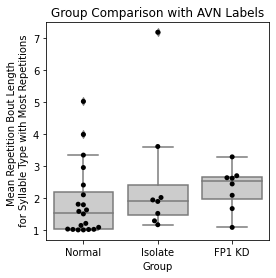

In [12]:
plt.figure(figsize = (4,4))
sns.boxplot(data = syll_level_syntax_full, x = 'Group', y = 'mean_repetition_length', color = '0.8')
sns.swarmplot(data = syll_level_syntax_full, x = 'Group', y = 'mean_repetition_length', color = 'black', s = 5)
plt.ylabel('Mean Repetition Bout Length \n for Syllable Type with Most Repetitions')
plt.title('Group Comparison with AVN Labels')

## Plot CV Repetition Bout Lengths

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
syll_level_syntax_full = pd.read_csv('repetition_stats_wseg_umap.csv')

In [21]:
syll_level_syntax_full.head(2)

,Unnamed: 0,mean_repetition_length,CV_repetition_length,Bird_ID
0,9,1.937500,0.644354,B145
1,0,1.890244,0.826235,B236


In [22]:
all_birds = pd.read_csv("E:\\Final_Bird_Dataset\\old_Bird_list.csv")
syll_level_syntax_full = pd.merge(syll_level_syntax_full, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Normal', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Normal'}
syll_level_syntax_full['Group'] = [group_dict[x] for x in syll_level_syntax_full.Condition]

In [23]:
isolates_AVN = syll_level_syntax_full.CV_repetition_length[syll_level_syntax_full.Group== 'Isolate']
normal_AVN = syll_level_syntax_full.CV_repetition_length[syll_level_syntax_full.Group == 'Normal']
FP1_AVN = syll_level_syntax_full.CV_repetition_length[syll_level_syntax_full.Group == 'FP1 KD']

In [24]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [25]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN)
print(fvalue, pvalue)

4.040206986273515 0.026946702031044874


In [26]:
tukey = pairwise_tukeyhsd(endog = syll_level_syntax_full['CV_repetition_length'], 
                          groups = syll_level_syntax_full['Group'], 
                          alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 FP1 KD Isolate   0.0552 0.8009 -0.1574  0.2678  False
 FP1 KD  Normal  -0.1334 0.1723 -0.3113  0.0445  False
Isolate  Normal  -0.1886 0.0358 -0.3665 -0.0107   True
------------------------------------------------------


In [27]:
syll_level_syntax_full.Group = syll_level_syntax_full.Group.astype('category').cat.set_categories(['Normal', 'Isolate', 'FP1 KD'], ordered = True)

Text(0.5, 1.0, 'Group Comparison with AVN Labels')

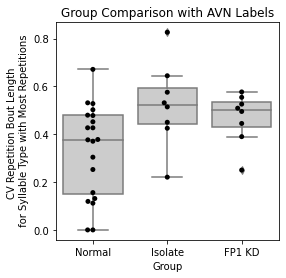

In [30]:
plt.figure(figsize = (4,4))
sns.boxplot(data = syll_level_syntax_full, x = 'Group', y = 'CV_repetition_length', color = '0.8')
sns.swarmplot(data = syll_level_syntax_full, x = 'Group', y = 'CV_repetition_length', color = 'black', s = 5)
plt.ylabel('CV Repetition Bout Length \n for Syllable Type with Most Repetitions')
plt.title('Group Comparison with AVN Labels')